<h1>Predicting West Nile Virus in Chicago</h1>
<h2>EDA and feature engineering, 2nd round</h2>

In [1]:
#importing relevant packages

import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

sns.set_style('whitegrid')

In [2]:
sp = pd.read_csv('./data/spray.csv.zip') #spray data
df= pd.read_csv('./data/train.csv.zip') #mosquito data
w = pd.read_csv('./data/weather.csv.zip') # weather data


<h2>Wrangling Weather</h2>
Filling missing values, breaking out weather events to separate columns, checking value types, and handling the two weather stations

In [3]:
w.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   object 
 5   Depart       2944 non-null   object 
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2944 non-null   object 
 8   Heat         2944 non-null   object 
 9   Cool         2944 non-null   object 
 10  Sunrise      2944 non-null   object 
 11  Sunset       2944 non-null   object 
 12  CodeSum      2944 non-null   object 
 13  Depth        2944 non-null   object 
 14  Water1       2944 non-null   object 
 15  SnowFall     2944 non-null   object 
 16  PrecipTotal  2944 non-null   object 
 17  StnPressure  2944 non-null   object 
 18  SeaLevel     2944 non-null   object 
 19  Result

In [4]:
w.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [5]:
w.Water1.value_counts()

M    2944
Name: Water1, dtype: int64

In [6]:
w = w.replace('M',np.nan)

In [7]:
w.SnowFall.value_counts()

0.0    1459
  T      12
0.1       1
Name: SnowFall, dtype: int64

In [8]:
w.Tavg.unique()

array(['67', '68', '51', '52', '56', '58', nan, '60', '59', '65', '70',
       '69', '71', '61', '55', '57', '73', '72', '53', '62', '63', '74',
       '75', '78', '76', '77', '66', '80', '64', '81', '82', '79', '85',
       '84', '83', '50', '49', '46', '48', '45', '54', '47', '44', '40',
       '41', '38', '39', '42', '37', '43', '86', '87', '89', '92', '88',
       '91', '93', '94', '90', '36'], dtype=object)

In [9]:
w.loc[:,'Tavg'] = w.loc[:,'Tavg'].astype('float')

In [10]:
w.Depart.unique()

array(['14', nan, '-3', ' 2', ' 4', ' 5', '10', '12', '13', '-2', '15',
       '11', '-4', '-6', ' 8', '-5', ' 1', ' 9', ' 6', '-9', '-8', ' 3',
       ' 0', '-1', '-7', ' 7', '-14', '18', '16', '22', '21', '20', '-10',
       '-16', '17', '-12', '-11', '-15', '-17', '19', '-13', '23'],
      dtype=object)

In [11]:
w.loc[:,'Depart'] = w.loc[:,'Depart'].astype('float')

In [12]:
w.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2933 non-null   float64
 5   Depart       1472 non-null   float64
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2940 non-null   object 
 8   Heat         2933 non-null   object 
 9   Cool         2933 non-null   object 
 10  Sunrise      2944 non-null   object 
 11  Sunset       2944 non-null   object 
 12  CodeSum      2944 non-null   object 
 13  Depth        1472 non-null   object 
 14  Water1       0 non-null      float64
 15  SnowFall     1472 non-null   object 
 16  PrecipTotal  2942 non-null   object 
 17  StnPressure  2940 non-null   object 
 18  SeaLevel     2935 non-null   object 
 19  Result

In [13]:
w.WetBulb.unique()

array(['56', '57', '47', '48', '50', '49', '46', '54', '53', '62', '63',
       '60', '61', '51', '59', '58', '43', '44', '45', '65', '66', '67',
       '64', '52', '55', '69', '68', '70', '72', '71', '73', '74', '76',
       '42', '39', '40', '41', '35', '33', '34', nan, '75', '36', '32',
       '38', '78', '77', '37'], dtype=object)

In [14]:
w['WetBulb'] = w['WetBulb'].astype('float')

In [15]:
w.Heat.unique()

array(['0', '14', '13', '9', '7', nan, '5', '6', '4', '10', '8', '12',
       '3', '2', '1', '15', '16', '19', '17', '20', '11', '18', '21',
       '25', '24', '27', '26', '23', '28', '22', '29'], dtype=object)

In [16]:
w.Cool.unique()

array([' 2', ' 3', ' 0', nan, ' 5', ' 4', ' 6', ' 8', ' 7', ' 9', '10',
       '13', '11', '12', ' 1', '15', '16', '17', '14', '20', '19', '18',
       '21', '22', '24', '27', '23', '26', '28', '29', '25'], dtype=object)

In [17]:
w['Heat'] = w['Heat'].astype('float')
w['Cool'] = w['Cool'].astype('float')

In [18]:
w.loc[:,'Sunrise':'Sunset'] = w.loc[:,'Sunrise':'Sunset'].replace('-',method='bfill')
w.loc[:,'Sunrise':'Sunset'] = w.loc[:,'Sunrise':'Sunset'].replace('-',method='ffill')
w.loc[:,'Sunrise':'Sunset'].isna().sum()

Sunrise    0
Sunset     0
dtype: int64

In [19]:
w.loc[:,'Sunrise':'Sunset'] = w.loc[:,'Sunrise':'Sunset'].astype('int')

In [20]:
w['sunrise_diff'] = w['Sunrise'].diff().fillna(0)
w['sunset_diff'] = w['Sunset'].diff().fillna(0)

In [21]:
w.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Station       2944 non-null   int64  
 1   Date          2944 non-null   object 
 2   Tmax          2944 non-null   int64  
 3   Tmin          2944 non-null   int64  
 4   Tavg          2933 non-null   float64
 5   Depart        1472 non-null   float64
 6   DewPoint      2944 non-null   int64  
 7   WetBulb       2940 non-null   float64
 8   Heat          2933 non-null   float64
 9   Cool          2933 non-null   float64
 10  Sunrise       2944 non-null   int64  
 11  Sunset        2944 non-null   int64  
 12  CodeSum       2944 non-null   object 
 13  Depth         1472 non-null   object 
 14  Water1        0 non-null      float64
 15  SnowFall      1472 non-null   object 
 16  PrecipTotal   2942 non-null   object 
 17  StnPressure   2940 non-null   object 
 18  SeaLevel      2935 non-null 

In [22]:
w.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,sunrise_diff,sunset_diff
0,1,2007-05-01,83,50,67.0,14.0,51,56.0,0.0,2.0,...,NaN,0.0,0.00,29.10,29.82,1.7,27,9.2,0.0,0.0
1,2,2007-05-01,84,52,68.0,NaN,51,57.0,0.0,3.0,...,NaN,NaN,0.00,29.18,29.82,2.7,25,9.6,-1.0,1.0
2,1,2007-05-02,59,42,51.0,-3.0,42,47.0,14.0,0.0,...,NaN,0.0,0.00,29.38,30.09,13.0,4,13.4,0.0,0.0
3,2,2007-05-02,60,43,52.0,NaN,42,47.0,13.0,0.0,...,NaN,NaN,0.00,29.44,30.08,13.3,2,13.4,-1.0,1.0
4,1,2007-05-03,66,46,56.0,2.0,40,48.0,9.0,0.0,...,NaN,0.0,0.00,29.39,30.12,11.7,7,11.9,0.0,0.0


In [23]:
w['Date'] = pd.to_datetime(w['Date'])

In [24]:
w = w.drop('Water1',axis=1)

In [25]:
w.head(10)

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,Depth,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,sunrise_diff,sunset_diff
0,1,2007-05-01,83,50,67.0,14.0,51,56.0,0.0,2.0,...,0,0.0,0.00,29.10,29.82,1.7,27,9.2,0.0,0.0
1,2,2007-05-01,84,52,68.0,NaN,51,57.0,0.0,3.0,...,NaN,NaN,0.00,29.18,29.82,2.7,25,9.6,-1.0,1.0
2,1,2007-05-02,59,42,51.0,-3.0,42,47.0,14.0,0.0,...,0,0.0,0.00,29.38,30.09,13.0,4,13.4,0.0,0.0
3,2,2007-05-02,60,43,52.0,NaN,42,47.0,13.0,0.0,...,NaN,NaN,0.00,29.44,30.08,13.3,2,13.4,-1.0,1.0
4,1,2007-05-03,66,46,56.0,2.0,40,48.0,9.0,0.0,...,0,0.0,0.00,29.39,30.12,11.7,7,11.9,0.0,0.0
5,2,2007-05-03,67,48,58.0,NaN,40,50.0,7.0,0.0,...,NaN,NaN,0.00,29.46,30.12,12.9,6,13.2,-2.0,1.0
6,1,2007-05-04,66,49,58.0,4.0,41,50.0,7.0,0.0,...,0,0.0,T,29.31,30.05,10.4,8,10.8,0.0,0.0
7,2,2007-05-04,78,51,NaN,NaN,42,50.0,NaN,NaN,...,NaN,NaN,0.00,29.36,30.04,10.1,7,10.4,-1.0,1.0
8,1,2007-05-05,66,53,60.0,5.0,38,49.0,5.0,0.0,...,0,0.0,T,29.40,30.10,11.7,7,12.0,0.0,0.0
9,2,2007-05-05,66,54,60.0,NaN,39,50.0,5.0,0.0,...,NaN,NaN,T,29.46,30.09,11.2,7,11.5,-1.0,2.0


In [26]:
w['Depth'] = w['Depth'].astype('float')
w.Depth.sum()

0.0

In [27]:
w = w.drop(['Depth','SnowFall'],axis=1)

In [28]:
w['PrecipTotal'] = w['PrecipTotal'].replace(['T','  T'],0.01)
w['PrecipTotal'] = w['PrecipTotal'].astype('float')
w['PrecipTotal'] = w['PrecipTotal'].fillna(0)

In [29]:
w = w.fillna(method='ffill')

In [30]:
w.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Station       2944 non-null   int64         
 1   Date          2944 non-null   datetime64[ns]
 2   Tmax          2944 non-null   int64         
 3   Tmin          2944 non-null   int64         
 4   Tavg          2944 non-null   float64       
 5   Depart        2944 non-null   float64       
 6   DewPoint      2944 non-null   int64         
 7   WetBulb       2944 non-null   float64       
 8   Heat          2944 non-null   float64       
 9   Cool          2944 non-null   float64       
 10  Sunrise       2944 non-null   int64         
 11  Sunset        2944 non-null   int64         
 12  CodeSum       2944 non-null   object        
 13  PrecipTotal   2944 non-null   float64       
 14  StnPressure   2944 non-null   object        
 15  SeaLevel      2944 non-null   object  

In [31]:
w[['StnPressure','SeaLevel','AvgSpeed']] = w[['StnPressure','SeaLevel','AvgSpeed']].astype('float')

In [32]:
#breaking out codesum into separate columns 
#getting a list of all unique codes in the weather set
codes = []
for code in w.CodeSum.unique():
    for c in code.split(' '):
        codes.append(c)
codes = pd.Series(codes)
codes = codes.unique()[1:]

#for each code, creating a column where value is 1 if happens, 0 if doesn't, then drop codeSum
for c in codes:
    col = [1 if c in s else 0 for s in w.CodeSum]
    
    if np.sum(col)>(len(col)/100): 
        w[c] = col

w = w.drop('CodeSum',axis=1)


In [33]:
#breaking two weather stations out based on station and merging together in one 
w_1 = w[w['Station']==1].drop('Station',axis=1)
w_2 = w[w['Station']==2].drop('Station',axis=1)

#merging back together on date with a variety of tactics

#keeping all data here
w_all = w_1.merge(w_2, on='Date').set_index('Date')

#averaging the two weather sets
w_avg = (w_1.set_index('Date') + w_2.set_index('Date')) / 2



<h2>Wrangling Mosquito data and spray data</h2>

In [35]:
sp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       14835 non-null  object 
 1   Time       14251 non-null  object 
 2   Latitude   14835 non-null  float64
 3   Longitude  14835 non-null  float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB


In [36]:
sp.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    10506 non-null  object 
 1   Address                 10506 non-null  object 
 2   Species                 10506 non-null  object 
 3   Block                   10506 non-null  int64  
 4   Street                  10506 non-null  object 
 5   Trap                    10506 non-null  object 
 6   AddressNumberAndStreet  10506 non-null  object 
 7   Latitude                10506 non-null  float64
 8   Longitude               10506 non-null  float64
 9   AddressAccuracy         10506 non-null  int64  
 10  NumMosquitos            10506 non-null  int64  
 11  WnvPresent              10506 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 985.1+ KB


In [38]:
df.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [39]:
#integrating spray data into mosquito data

mi_per_deg_lat = 364000/5280 #36400 ft per degree lat
mi_per_deg_long = 288200/5280 #288200 ft per degree long

#chaning date columns to pandas datetime for easy handling
sp['Date'] = pd.to_datetime(sp['Date'])
df['Date'] = pd.to_datetime(df['Date'])


def sprayed(dist, time, traps, sprays):
    """Returns wether or not a mosquito trap locations was sprayed within a certain distance and time frame. 
    Distance is in miles, time is 0 for year, 1 for month, and 2 for day. d is dataset"""
    s = []
    #for each trap, find the distances to all sprays within the timeframe, if the miniumum is below 
    # the threshold, than it was sprayed during that time period
    period = {0:'y',1:'m',2:'d'}
    
    for i,r  in traps.iterrows():
       
        #creating a mask to select relevant spray locations based on date
        mask = sprays['Date'].dt.to_period(period[time]) == r[0].to_period(period[time]) 
        
        #passing the loop if there are no sprays during the right window
        if mask.sum() == 0:
            s.append(0)
            continue
        spray = sprays[mask]
        
        #finding euclidian distance based on lat/long converted to miles
        lat_d = (spray.iloc[:,2]-r[7]) * mi_per_deg_lat
        long_d = (spray.iloc[:,3]-r[8])* mi_per_deg_long
        d = np.sqrt(lat_d**2 + long_d**2)
        
        #if the closest spray in the time period is within the cutoff distance, assign 1, otherwise 0
        if d.min() <= dist:
            s.append(1) 
        else: 
            s.append(0)

    return s

    


    


In [40]:
df['spray_year'] = sprayed(1,0,df,sp)
df['spray_month'] = sprayed(1,1,df,sp)
df['spray_day'] = sprayed(1,2,df,sp)

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    10506 non-null  datetime64[ns]
 1   Address                 10506 non-null  object        
 2   Species                 10506 non-null  object        
 3   Block                   10506 non-null  int64         
 4   Street                  10506 non-null  object        
 5   Trap                    10506 non-null  object        
 6   AddressNumberAndStreet  10506 non-null  object        
 7   Latitude                10506 non-null  float64       
 8   Longitude               10506 non-null  float64       
 9   AddressAccuracy         10506 non-null  int64         
 10  NumMosquitos            10506 non-null  int64         
 11  WnvPresent              10506 non-null  int64         
 12  spray_year              10506 non-null  int64 

In [42]:
df['spray_day'].sum()

60

In [43]:
df['spray_month'].sum()

402

In [44]:
df['spray_year'].sum()

1184

In [45]:
df = df.drop(['Address','Block','Street','AddressNumberAndStreet','AddressAccuracy'],axis=1)

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          10506 non-null  datetime64[ns]
 1   Species       10506 non-null  object        
 2   Trap          10506 non-null  object        
 3   Latitude      10506 non-null  float64       
 4   Longitude     10506 non-null  float64       
 5   NumMosquitos  10506 non-null  int64         
 6   WnvPresent    10506 non-null  int64         
 7   spray_year    10506 non-null  int64         
 8   spray_month   10506 non-null  int64         
 9   spray_day     10506 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(5), object(2)
memory usage: 820.9+ KB


<h2>EDA</h2>

In [47]:
df.groupby('Species').describe().T

Species             CULEX ERRATICUS  CULEX PIPIENS  CULEX PIPIENS/RESTUANS  \
Latitude     count         1.000000    2699.000000             4752.000000   
             mean         41.974689      41.813402               41.848832   
             std                NaN       0.115259                0.110800   
             min          41.974689      41.644612               41.644612   
             25%          41.974689      41.704572               41.750498   
             50%          41.974689      41.793818               41.868077   
             75%          41.974689      41.923738               41.954690   
             max          41.974689      42.017430               42.017430   
Longitude    count         1.000000    2699.000000             4752.000000   
             mean        -87.890615     -87.680481              -87.705241   
             std                NaN       0.095400                0.095853   
             min         -87.890615     -87.930995              -87.930995   
             25%         -87.890615     -87.745602              -87.763416   
             50%         -87.890615     -87.674677              -87.700117   
             75%         -87.890615     -87.599862              -87.642984   
             max         -87.890615     -87.531635              -87.531635   
NumMosquitos count         1.000000    2699.000000             4752.000000   
             mean          7.000000      16.550945               13.945286   
             std                NaN      19.040433               15.995301   
             min           7.000000       1.000000                1.000000   
             25%           7.000000       2.000000                2.000000   
             50%           7.000000       6.000000                6.000000   
             75%           7.000000      31.000000               20.000000   
             max           7.000000      50.000000               50.000000   
WnvPresent   count         1.000000    2699.000000             4752.000000   
             mean          0.000000       0.088922                0.055135   
             std                NaN       0.284684                0.228267   
             min           0.000000       0.000000                0.000000   
             25%           0.000000       0.000000                0.000000   
             50%           0.000000       0.000000                0.000000   
             75%           0.000000       0.000000                0.000000   
             max           0.000000       1.000000                1.000000   
spray_year   count         1.000000    2699.000000             4752.000000   
             mean          0.000000       0.082253                0.118687   
             std                NaN       0.274800                0.323454   
             min           0.000000       0.000000                0.000000   
             25%           0.000000       0.000000                0.000000   
             50%           0.000000       0.000000                0.000000   
             75%           0.000000       0.000000                0.000000   
             max           0.000000       1.000000                1.000000   
spray_month  count         1.000000    2699.000000             4752.000000   
             mean          0.000000       0.034828                0.039352   
             std                NaN       0.183377                0.194451   
             min           0.000000       0.000000                0.000000   
             25%           0.000000       0.000000                0.000000   
             50%           0.000000       0.000000                0.000000   
             75%           0.000000       0.000000                0.000000   
             max           0.000000       1.000000                1.000000   
spray_day    count         1.000000    2699.000000             4752.000000   
             mean          0.000000       0.005558                0.005892   
             std      

<AxesSubplot:xlabel='WnvPresent', ylabel='Species'>

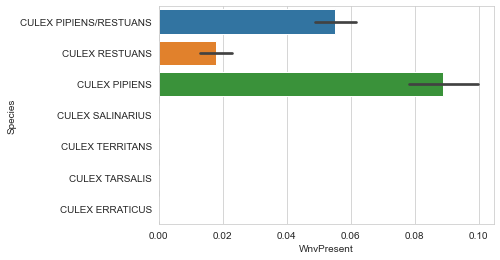

In [48]:
sns.barplot(data=df,y='Species',x='WnvPresent')


Really important finding here! WNV is only in two mosquito species

In [49]:
df['cul_or_pip'] = [1 if s in ['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS'] else 0 for s in df.Species]

df_all = df.merge(w_all.reset_index(),on='Date')
df_avg = df.merge(w_avg.reset_index(),on='Date')

<AxesSubplot:xlabel='WnvPresent', ylabel='Tavg'>

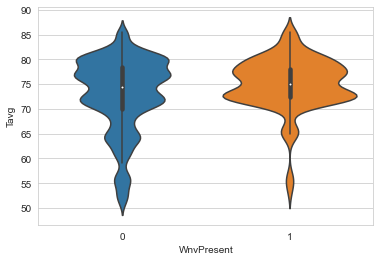

In [50]:
sns.violinplot(data=df_avg,x='WnvPresent',y='Tavg')

In [51]:
df_avg.WnvPresent.corr(df_avg.Tavg)

0.0642559817674728

As you might expect, warmer temperatures mean more mosquitos. Correlation indicates that there is not a linear relationship. As long as it's warm enough, mosquitos are out! 

<AxesSubplot:xlabel='WnvPresent', ylabel='PrecipTotal'>

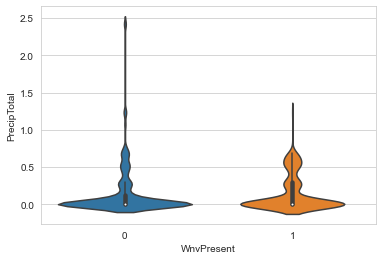

In [52]:
sns.violinplot(data=df_avg,x='WnvPresent',y='PrecipTotal')

High precipitation day-of trends towards fewer mosquitos. I wonder what it looks like with rolling average?

In [53]:
#rolling total pepceiption on a few different time scales. 
w_avg['three_day_rain'] = w_avg['PrecipTotal'].rolling(3, min_periods=1).sum()
w_avg['week_rain'] = w_avg['PrecipTotal'].rolling(7, min_periods=1).sum()
w_avg['two_week_rain'] = w_avg['PrecipTotal'].rolling(14, min_periods=1).sum()
w_avg['month_rain'] = w_avg['PrecipTotal'].rolling(28, min_periods=1).sum()

#and for the separate weather stations
w_all['three_day_rain_x'] = w_all['PrecipTotal_x'].rolling(3, min_periods=1).sum()
w_all['week_rain_x'] = w_all['PrecipTotal_x'].rolling(7, min_periods=1).sum()
w_all['two_week_rain_x'] = w_all['PrecipTotal_x'].rolling(14, min_periods=1).sum()
w_all['month_rain_x'] = w_all['PrecipTotal_x'].rolling(28, min_periods=1).sum()

w_all['three_day_rain_y'] = w_all['PrecipTotal_y'].rolling(3, min_periods=1).sum()
w_all['week_rain_y'] = w_all['PrecipTotal_y'].rolling(7, min_periods=1).sum()
w_all['two_week_rain_y'] = w_all['PrecipTotal_y'].rolling(14, min_periods=1).sum()
w_all['month_rain_y'] = w_all['PrecipTotal_y'].rolling(28, min_periods=1).sum()

In [54]:
df_avg = df.merge(w_avg.reset_index(),on='Date')
df_all = df.merge(w_all.reset_index(),on='Date')

<AxesSubplot:xlabel='WnvPresent', ylabel='three_day_rain'>

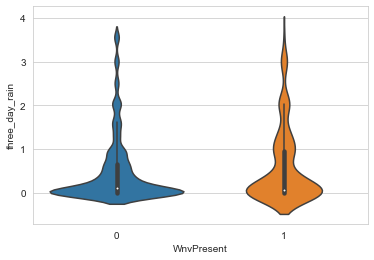

In [55]:
sns.violinplot(data=df_avg,x='WnvPresent',y='three_day_rain')

<AxesSubplot:xlabel='WnvPresent', ylabel='week_rain'>

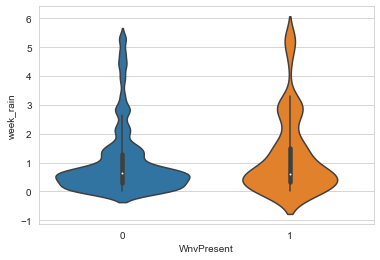

In [56]:
sns.violinplot(data=df_avg,x='WnvPresent',y='week_rain')

<AxesSubplot:xlabel='WnvPresent', ylabel='two_week_rain'>

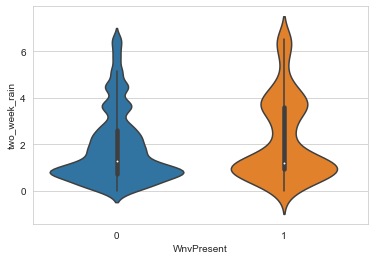

In [57]:
sns.violinplot(data=df_avg,x='WnvPresent',y='two_week_rain')

<AxesSubplot:xlabel='WnvPresent', ylabel='month_rain'>

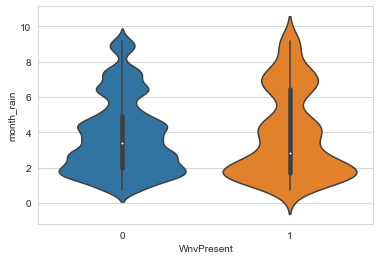

In [58]:
sns.violinplot(data=df_avg,x='WnvPresent',y='month_rain')

<AxesSubplot:>

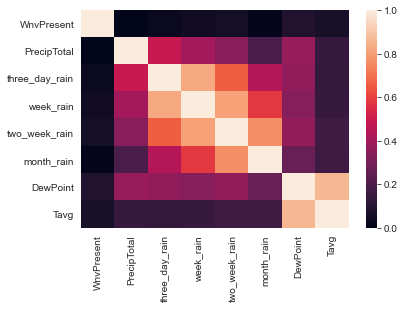

In [59]:
subset = df_avg[['WnvPresent','PrecipTotal','three_day_rain','week_rain','two_week_rain',
                'month_rain','DewPoint','Tavg']]
sns.heatmap(subset.corr())

In [60]:
corr = df_avg.corr()
corr['WnvPresent']



Latitude          0.028697
Longitude        -0.060345
NumMosquitos      0.196820
WnvPresent        1.000000
spray_year        0.078184
spray_month       0.115555
spray_day         0.050164
cul_or_pip        0.041362
Tmax              0.048244
Tmin              0.074048
Tavg              0.064256
Depart            0.055436
DewPoint          0.085883
WetBulb           0.079363
Heat             -0.054740
Cool              0.058101
Sunrise           0.111944
Sunset           -0.068844
PrecipTotal      -0.000577
StnPressure       0.010128
SeaLevel          0.006480
ResultSpeed      -0.046298
ResultDir         0.000175
AvgSpeed         -0.029416
sunrise_diff      0.079836
sunset_diff      -0.107039
BR                0.044808
HZ                0.016236
RA                0.009714
TSRA              0.043148
TS                0.047925
DZ               -0.019889
FG                0.098846
three_day_rain    0.029163
week_rain         0.045091
two_week_rain     0.052931
month_rain        0.009032
N

<AxesSubplot:xlabel='WnvPresent', ylabel='spray_month'>

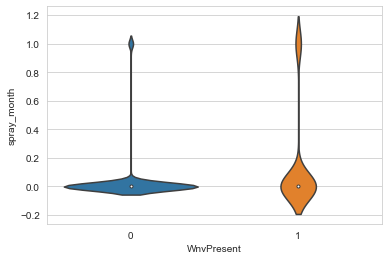

In [61]:
sns.violinplot(data=df_avg,x='WnvPresent',y='spray_month')

<AxesSubplot:xlabel='WnvPresent', ylabel='Sunrise'>

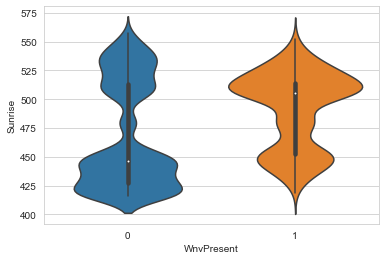

In [62]:
sns.violinplot(data=df_avg,x='WnvPresent',y='Sunrise')

<AxesSubplot:xlabel='WnvPresent', ylabel='SeaLevel'>

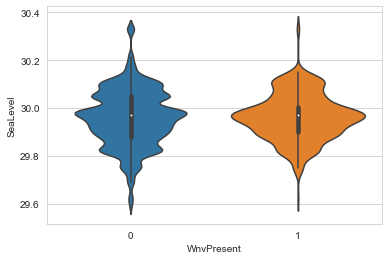

In [63]:
sns.violinplot(data=df_avg,x='WnvPresent',y='SeaLevel')

<AxesSubplot:xlabel='WnvPresent', ylabel='AvgSpeed'>

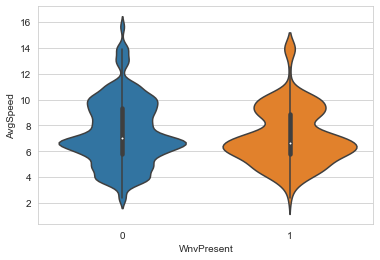

In [64]:
sns.violinplot(data=df_avg,x='WnvPresent',y='AvgSpeed')

<AxesSubplot:xlabel='WnvPresent', ylabel='DewPoint'>

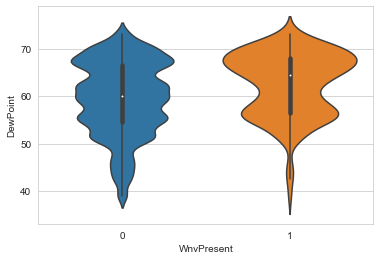

In [65]:
sns.violinplot(data=df_avg,x='WnvPresent',y='DewPoint')

In [66]:
df_avg['T_spread'] = df_avg.Tmax - df_avg.Tmin
df_avg['longer_days'] = [1 if r[0] - r[1] > 0 else 0 for i,r in df_avg[['sunset_diff','sunrise_diff']].iterrows()]


In [67]:
df_avg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10506 entries, 0 to 10505
Data columns (total 42 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            10506 non-null  datetime64[ns]
 1   Species         10506 non-null  object        
 2   Trap            10506 non-null  object        
 3   Latitude        10506 non-null  float64       
 4   Longitude       10506 non-null  float64       
 5   NumMosquitos    10506 non-null  int64         
 6   WnvPresent      10506 non-null  int64         
 7   spray_year      10506 non-null  int64         
 8   spray_month     10506 non-null  int64         
 9   spray_day       10506 non-null  int64         
 10  cul_or_pip      10506 non-null  int64         
 11  Tmax            10506 non-null  float64       
 12  Tmin            10506 non-null  float64       
 13  Tavg            10506 non-null  float64       
 14  Depart          10506 non-null  float64       
 15  De

<h3>Correlations for lagged weather variables</h3>

Here I will explore how correlation changes based on the lag in the variable. For each variable, I will save the index (lag or span) that produced the best correlation

In [139]:
w_avg['longer_days'] = [1 if r[1] - r[0] > 0 else 0 for i, r in w_avg[['sunrise_diff','sunset_diff']].iterrows()]
w_avg['T_spread'] = w_avg.Tmax - w_avg.Tmin
w_avg['rainy_and_hot'] = pd.qcut(w_avg.Tmax,5,labels=range(0,5)).astype('float') + pd.cut(
    w_avg.PrecipTotal,5,labels=range(0,5)).astype('float')


In [140]:
#lagged weather
def lagged(df,n):
    return df.rolling(n).mean().dropna()

def exp_lag(df,n):
    return df.ewm(span=n).mean().dropna()

w_exp = {s:exp_lag(w_avg,s) for s in np.arange(2,60)}
w_lag = {s:lagged(w_avg,s) for s in np.arange(2,60)}

In [141]:
def lag_corr(weather, data=df):
    best_corr = {c:[0,0] for c in df.merge(weather[2].reset_index(),on='Date').columns}
    for lag,w_df in weather.items():
        d = data.merge(w_df.reset_index(),on='Date')
        for i, corr in d.corr()['WnvPresent'].iteritems():
            if np.abs(best_corr[i][1]) < np.abs(corr):
                best_corr[i][1] = corr
                best_corr[i][0] = lag
        
    return best_corr

In [142]:
lag_df = pd.DataFrame(lag_corr(w_lag,df)).T
ewm_df = pd.DataFrame(lag_corr(w_exp,df)).T
ewm_df

,0,1
Date,0.0,0.000000
Species,0.0,0.000000
Trap,0.0,0.000000
Latitude,2.0,0.028697
Longitude,2.0,-0.060345
NumMosquitos,2.0,0.196820
WnvPresent,2.0,1.000000
spray_year,2.0,0.078184
spray_month,2.0,0.115555
spray_day,2.0,0.050164


In [143]:
diff = np.abs(lag_df) - np.abs(ewm_df)
# if 1, lagged approach is best, if -1, exp lag is best
def pos_neg(x):
    if x < 0:
        return -1
    elif x == 0:
        return 0
    elif x > 0:
        return 1

choice = diff.loc[:,1].apply(pos_neg)
choice

Date              0
Species           0
Trap              0
Latitude          1
Longitude         1
NumMosquitos      0
WnvPresent        0
spray_year        0
spray_month       0
spray_day         0
cul_or_pip        1
Tmax              1
Tmin             -1
Tavg             -1
Depart            1
DewPoint         -1
WetBulb          -1
Heat             -1
Cool              1
Sunrise          -1
Sunset            1
PrecipTotal       1
StnPressure       1
SeaLevel          1
ResultSpeed       1
ResultDir         1
AvgSpeed          1
sunrise_diff      1
sunset_diff       1
BR                1
HZ                1
RA                1
TSRA              1
TS                1
DZ                1
FG                1
three_day_rain    1
week_rain         1
two_week_rain     1
month_rain        1
longer_days       1
T_spread          1
rainy_and_hot     1
Name: 1, dtype: int64

In [144]:
df_best = df

for col in w_lag[2].columns:
    c = choice[col]
    if c == -1:
        lag = ewm_df.loc[col][0]
        best_col = w_exp[lag][col].reset_index()
        df_best = df_best.merge(best_col, on='Date')
        cols = list(df_best.columns)
        cols[-1] = col + ' ' + str(lag) + ' ewm'
        df_best.columns = cols
        
    elif c == 1:
        lag = lag_df.loc[col][0]
        best_col = w_lag[lag][col].reset_index()
        df_best = df_best.merge(best_col, on='Date')
        cols = list(df_best.columns)
        cols[-1]= col + ' ' + str(lag) + ' lag'
        df_best.columns = cols

In [145]:
df_best.corr()['WnvPresent']

Latitude                   0.030364
Longitude                 -0.061089
NumMosquitos               0.195298
WnvPresent                 1.000000
spray_year                 0.077033
spray_month                0.114934
spray_day                  0.049920
cul_or_pip                 0.041940
Tmax 59.0 lag              0.137975
Tmin 59.0 ewm              0.154917
Tavg 59.0 ewm              0.147498
Depart 3.0 lag             0.070700
DewPoint 59.0 ewm          0.163484
WetBulb 59.0 ewm           0.158672
Heat 59.0 ewm             -0.137652
Cool 59.0 lag              0.146471
Sunrise 2.0 ewm            0.105891
Sunset 5.0 lag            -0.067520
PrecipTotal 59.0 lag      -0.068424
StnPressure 32.0 lag       0.090062
SeaLevel 32.0 lag          0.078761
ResultSpeed 32.0 lag      -0.141801
ResultDir 4.0 lag          0.040657
AvgSpeed 32.0 lag         -0.140936
sunrise_diff 23.0 lag      0.204976
sunset_diff 28.0 lag      -0.136952
BR 48.0 lag               -0.089179
HZ 10.0 lag               -0

<AxesSubplot:xlabel='WnvPresent', ylabel='DewPoint 59.0 ewm'>

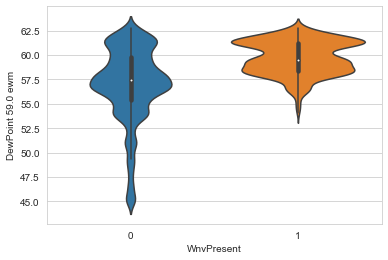

In [146]:
sns.violinplot(data=df_best,x='WnvPresent',y='DewPoint 59.0 ewm')

<AxesSubplot:xlabel='WnvPresent', ylabel='Heat 59.0 ewm'>

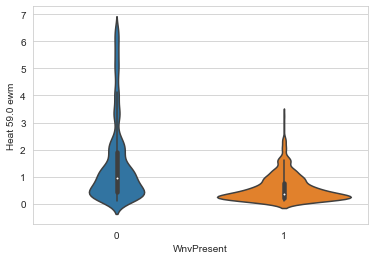

In [147]:
sns.violinplot(data=df_best,x='WnvPresent',y='Heat 59.0 ewm')

<AxesSubplot:xlabel='WnvPresent', ylabel='Tmax 59.0 lag'>

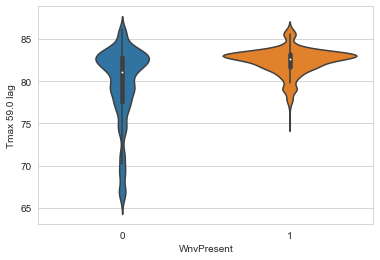

In [148]:
sns.violinplot(data=df_best,x='WnvPresent',y='Tmax 59.0 lag')

<AxesSubplot:xlabel='Tmax 59.0 lag', ylabel='Count'>

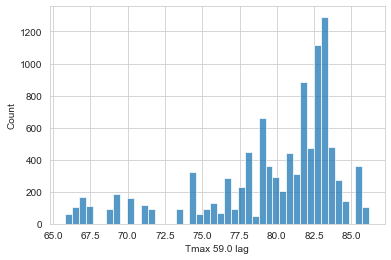

In [149]:
sns.histplot(data=df_best,x='Tmax 59.0 lag')

<AxesSubplot:xlabel='WnvPresent', ylabel='Sunrise 2.0 ewm'>

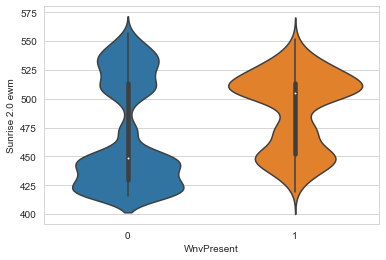

In [150]:
sns.violinplot(data=df_best,x='WnvPresent',y='Sunrise 2.0 ewm')

<AxesSubplot:xlabel='WnvPresent', ylabel='ResultSpeed 32.0 lag'>

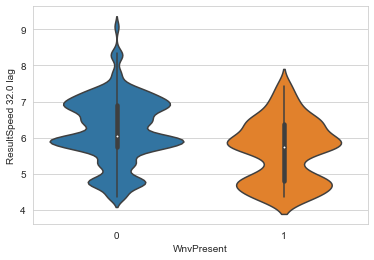

In [151]:
sns.violinplot(data=df_best,x='WnvPresent',y='ResultSpeed 32.0 lag')

<AxesSubplot:>

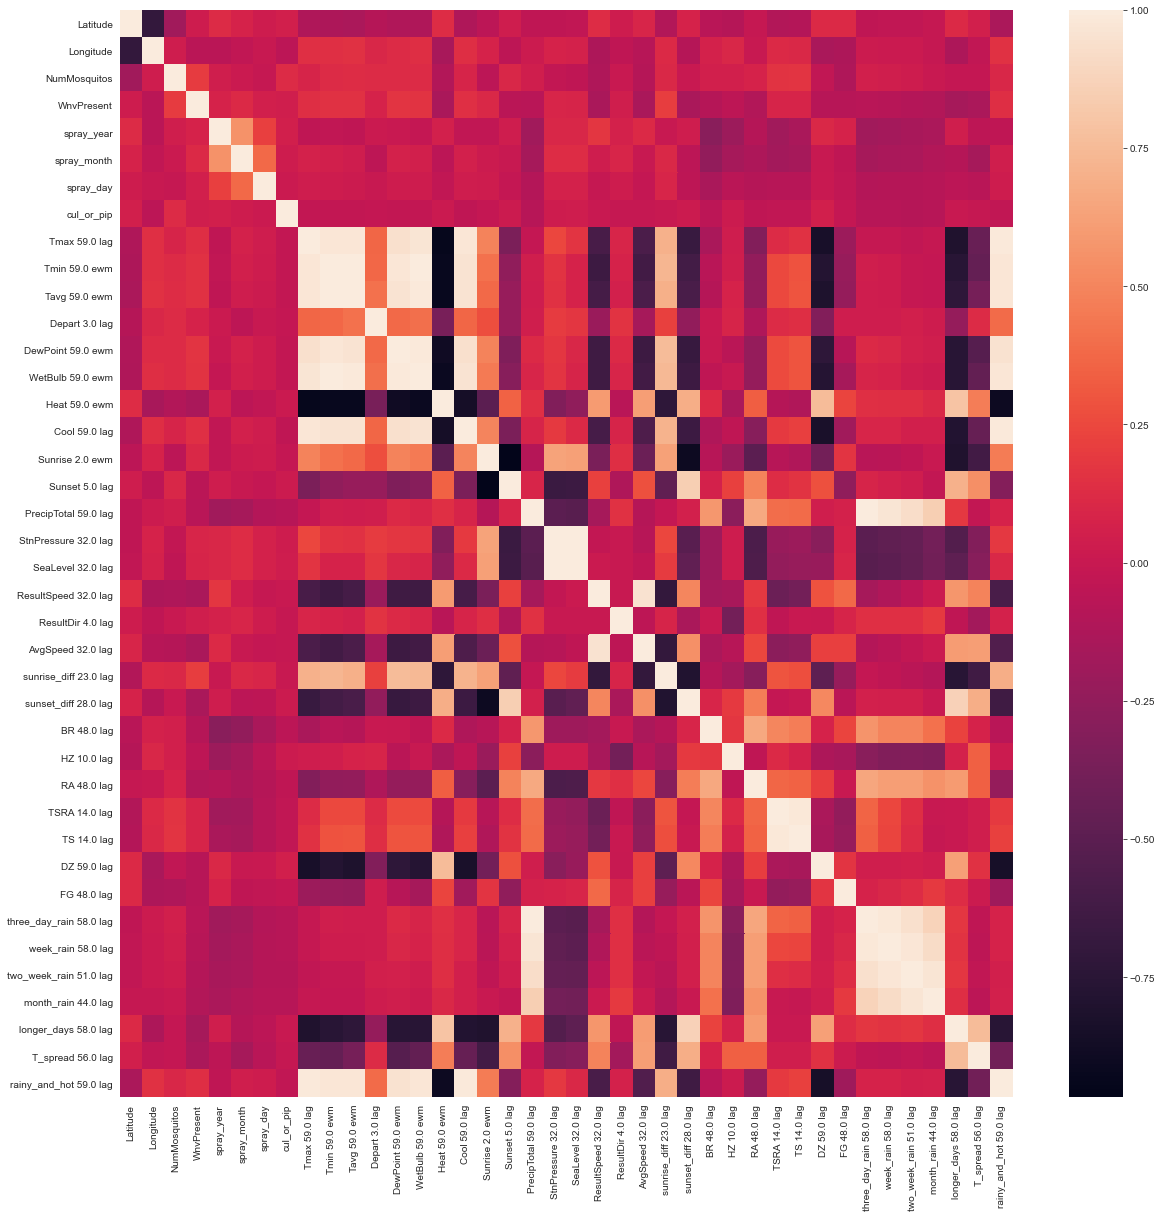

In [152]:
ax = plt.figure(figsize=(20,20))

sns.heatmap(df_best.corr())

In [153]:
df_best.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10351 entries, 0 to 10350
Data columns (total 43 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Date                     10351 non-null  datetime64[ns]
 1   Species                  10351 non-null  object        
 2   Trap                     10351 non-null  object        
 3   Latitude                 10351 non-null  float64       
 4   Longitude                10351 non-null  float64       
 5   NumMosquitos             10351 non-null  int64         
 6   WnvPresent               10351 non-null  int64         
 7   spray_year               10351 non-null  int64         
 8   spray_month              10351 non-null  int64         
 9   spray_day                10351 non-null  int64         
 10  cul_or_pip               10351 non-null  int64         
 11  Tmax 59.0 lag            10351 non-null  float64       
 12  Tmin 59.0 ewm            10351 n

In [155]:
max_bin = 20
force_bin = 3

def mono_bin(Y, X, n = max_bin):
    
    np.seterr(divide='ignore')
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = np.divide(d3.EVENT,d3.COUNT)
    d3["NON_EVENT_RATE"] = np.divide(d3.NONEVENT,d3.COUNT)
    d3["DIST_EVENT"] = np.divide(d3.EVENT,d3.sum().EVENT)
    d3["DIST_NON_EVENT"] = np.divide(d3.NONEVENT,d3.sum().NONEVENT)
    d3["WOE"] = np.log(np.divide(d3.DIST_EVENT,d3.DIST_NON_EVENT))
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*d3.WOE
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    
    d3["EVENT_RATE"] = np.divide(d3.EVENT,d3.COUNT)
    d3["NON_EVENT_RATE"] = np.divide(d3.NONEVENT,d3.COUNT)
    d3["DIST_EVENT"] = np.divide(d3.EVENT,d3.sum().EVENT)
    d3["DIST_NON_EVENT"] = np.divide(d3.NONEVENT,d3.sum().NONEVENT)
    d3["WOE"] = np.log(np.divide(d3.DIST_EVENT,d3.DIST_NON_EVENT))
    
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(pd.Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [156]:
df_ivs, IV = data_vars(df_best.drop('WnvPresent',axis=1),df_best['WnvPresent'])
to_drop = IV[(IV.IV > 0.8) | (IV.IV < 0.02)].drop(29)
df_iv = df_best.drop(to_drop.VAR_NAME, axis=1)
df_iv = df_iv.drop(['spray_year','spray_day','Trap','Species'],axis=1)

In [174]:
features = ['spray_month','Tavg 59.0 ewm','Depart 3.0 lag','PrecipTotal 59.0 lag','longer_days 58.0 lag',
           'ResultSpeed 32.0 lag','HZ 10.0 lag','BR 48.0 lag','T_spread 56.0 lag']
df_X = df_iv[features]

<h2>Conclusions / Notes</h2>

1. Mosquitos are only present in CULEX PIPIENS/RESTUANS. I should combine the mosquito species data into a yes or no columns on species

2. Lagging variables is incredbily important. For each variable, I was able to select the lag that correlated the variable most strongly with WnvPresent. I use a mixed approach of exponentially weighted moving averages and uniformly wieghted. 

In [175]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def iterate_vif(df, vif_threshold=10, max_vif=11):
  count = 0
  while max_vif > vif_threshold:
    count += 1
    print("Iteration # "+str(count))
    vif = pd.DataFrame()
    vif["VIFactor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif["features"] = df.columns
    
    if np.round(vif['VIFactor'].max(),1) > vif_threshold:
      print('Removing %s with VIF of %f' % (vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], np.round(vif['VIFactor'].max(),1)))
      df = df.drop(vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], axis=1)
      max_vif = np.round(vif['VIFactor'].max(),1)
    else:
        print('Complete')
        return df, np.round(vif.sort_values('VIFactor'),1)

In [176]:
X = df_X
y = df_iv.WnvPresent

In [177]:
X2, vif = iterate_vif(X._get_numeric_data())

Iteration # 1
Removing T_spread 56.0 lag with VIF of 1287.000000
Iteration # 2
Removing Tavg 59.0 ewm with VIF of 110.800000
Iteration # 3
Removing BR 48.0 lag with VIF of 25.900000
Iteration # 4
Removing ResultSpeed 32.0 lag with VIF of 12.200000
Iteration # 5
Complete


In [178]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

X2.to_pickle('./data/X2.pkl')
y.to_pickle('./data/y.pkl')

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X2,y, test_size = 0.2, random_state = 42)

In [180]:
rf = RandomForestClassifier()

params = {'n_estimators': np.arange(750,2000,50),'max_depth': np.arange(3,8)}

rf_rand = RandomizedSearchCV(rf,param_distributions=params,cv=5, n_jobs=-1, scoring = 'roc_auc',n_iter=10,
                            random_state = 42, verbose=10)

In [181]:
rf_rand.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   38.5s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   43.1s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   44.8s finished


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': array([3, 4, 5, 6, 7]),
                                        'n_estimators': array([ 750,  800,  850,  900,  950, 1000, 1050, 1100, 1150, 1200, 1250,
       1300, 1350, 1400, 1450, 1500, 1550, 1600, 1650, 1700, 1750, 1800,
       1850, 1900, 1950])},
                   random_state=42, scoring='roc_auc', verbose=10)

In [182]:
rf_rand.best_score_

0.8063778849745071

In [183]:
from sklearn.metrics import roc_auc_score

y_pred = rf_rand.best_estimator_.predict_proba(X_test)

roc_auc_score(y_test,y_pred[:,1])


0.8180671119412841

<AxesSubplot:xlabel='importance', ylabel='feature'>

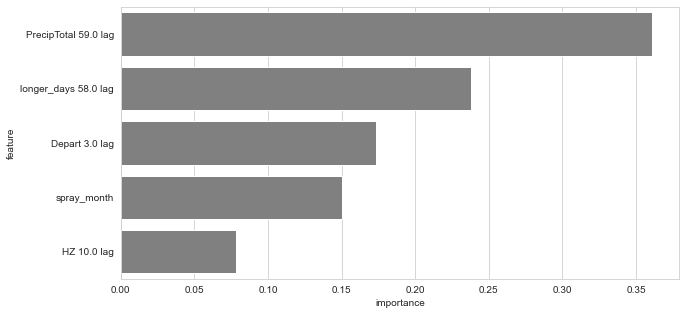

In [190]:
r = rf_rand.best_estimator_
imp = r.feature_importances_

ax = plt.figure(figsize=(10,5))

i = pd.DataFrame({'feature':X_test.columns,'importance':imp}).sort_values('importance',ascending=False)

sns.barplot(data=i,y='feature',x='importance',orient='h',color='gray')

In [185]:
from sklearn.metrics import roc_curve

def roc_plot(e,x,y):
    """e is estimator, x is data and y is true value"""

    #predicting from model
    y_pred = e.predict_proba(x)[:,1]

    #finding curve
    fpr, tpr, t = roc_curve(y, y_pred)
    sns.lineplot(x=fpr,y=tpr)
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.title('Compute Receiver Operating Characteristic Curve')
    return pd.DataFrame({'fpr':fpr,'tpr':tpr,'threshold':t})

from sklearn.metrics import roc_auc_score


def test_comp(e):
    #predicting probability from test set
    y_pred = e.predict_proba(X_test)[:,1]
    
    
    r = np.round(roc_auc_score(y_test,y_pred),3)
    
    print('Evaluating the classifier on the test set, area under the roc curve is: ' +  
           '{}'.format(r))

test_comp(rf_rand.best_estimator_)

Evaluating the classifier on the test set, area under the roc curve is: 0.818


In [186]:
test_comp(rf_rand.best_estimator_)

Evaluating the classifier on the test set, area under the roc curve is: 0.818


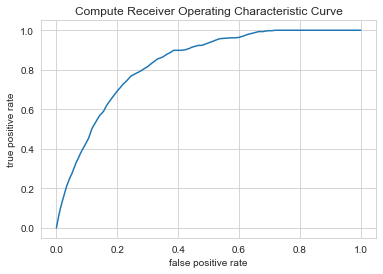

In [187]:
est = rf_rand.best_estimator_
c = roc_plot(est, X_train, y_train)